In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlrose
import numpy as np
from time import perf_counter
import copy
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

In [3]:
def param_grid_combinations(param_grid):
    """Returns a list of dicts of all param_grid settings combinations"""
    param_val_tuple_lists = []
    for param_name in sorted(param_grid):
        param_val_tuple_lists.append([])
        values = param_grid[param_name]

        # Catch strings which may look like iterables but don't make the cut below...
        if isinstance(values, str):
            values = [values]

        # Does it look like an iterable?  If not, promote
        try:
            values = values[:]
        except TypeError:
            values = [values]

        # Store as a list of (param_name, param_value) tuples
        for value in values:
            param_val_tuple_lists[-1].append((param_name, value))

    settings_combinations = list(itertools.product(*param_val_tuple_lists))
    settings_as_dicts = [dict(settings) for settings in settings_combinations]
    return settings_as_dicts

In [4]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# Maximum iterations for iterative classification trainers
maxIter = 3000

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [5]:
# Used for plot names
est = "fraud_mlrose"
scoreText = "F1-Score"

In [6]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

# Use all features except time (omitting as I don't want to handle anything time-series related)
featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [7]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


In [8]:
hidden_layer_sizes = (4,)
results = {}
data = {
    'train': {'X': X, 'y': y},
    'test': {'X': XTest, 'y': yTest},
}


# Benchmark using MLPClassifier (sklearn)

In [9]:
np.random.seed(7)
clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000 )
time_start = perf_counter()
clf.fit(X, y)
fit_time = perf_counter() - time_start
print(f'fit_time = {fit_time}')


fit_time = 1.4831620999999995


case: train, f1=0.9424307036247334
case: test, f1=0.6700680272108844


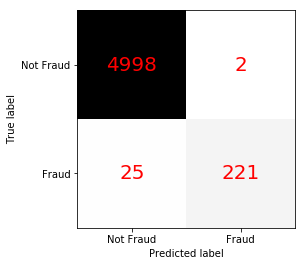

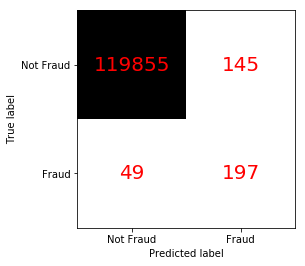

In [10]:
thisResult = {'fit_time': fit_time}
for case in data:
    thisResult[case] = {}
    thisResult[case]['yPred'] = clf.predict(data[case]['X'])
    thisResult[case]['f1'] = f1_score(data[case]['y'], thisResult[case]['yPred'])
    thisResult[case]['cr'] = classification_report(data[case]['y'], thisResult[case]['yPred'], target_names=names)
    print(f'case: {case}, f1={thisResult[case]["f1"]}')
    thisResult[case]['cm'] = plotConfusionMatrix(data[case]['y'], thisResult[case]['yPred'], names, savefig=f'NN_adam_confusion_{case}.png')
results['sklearn'] = thisResult

# Using Random Hill Climbing

In [11]:
np.random.seed(7)

clf = mlrose.NeuralNetwork(hidden_nodes=[4], algorithm='random_hill_climb', restarts=5, max_attempts=1000, max_iters=1000)
time_start = perf_counter()
clf.fit(X, y)
fit_time = perf_counter() - time_start
print(f'fit_time = {fit_time}')

fit_time = 36.4082387


case: train, f1=0.9173913043478261
case: test, f1=0.7167630057803469
Fitness function evaluations = 8833


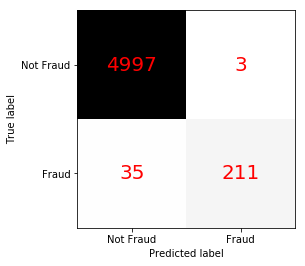

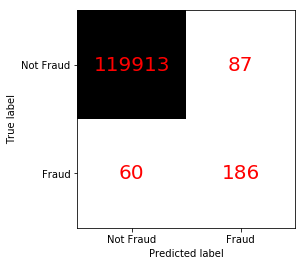

In [12]:
thisResult = {'fit_time': fit_time}
thisResult['fit_statistics'] = clf.fit_statistics
for case in data:
    thisResult[case] = {}
    thisResult[case]['yPred'] = clf.predict(data[case]['X'])
    thisResult[case]['f1'] = f1_score(data[case]['y'], thisResult[case]['yPred'])
    thisResult[case]['cr'] = classification_report(data[case]['y'], thisResult[case]['yPred'], target_names=names)
    print(f'case: {case}, f1={thisResult[case]["f1"]}')
    thisResult[case]['cm'] = plotConfusionMatrix(data[case]['y'], thisResult[case]['yPred'], names, savefig=f'NN_rhc_confusion_{case}.png')
print(f'Fitness function evaluations = {thisResult["fit_statistics"]["fitness_evals"]}')
results['Random Hill Climb'] = thisResult


In [13]:
results['Random Hill Climb']['fit_statistics']

{'fitness_history': array([0.07019939, 0.12904362, 0.17659443, 0.09268765, 0.18449949,
        0.11788437]),
 'state_history': array([[-3.47383421e-01,  5.59837584e-01,  5.76818463e-01,
          4.69303557e-02,  3.55979024e-01, -2.30082592e-02,
         -4.97759073e-01, -3.55897733e-01,  3.68779602e-02,
         -2.34998349e-04,  6.58459992e-01,  1.07478072e-01,
         -3.38117734e-01, -7.68127306e-01, -7.23708801e-01,
          1.01918706e+00, -5.73229293e-01, -9.57520764e-02,
          5.62412039e-01, -5.50201545e-01,  7.01097835e-01,
          9.00259001e-01, -3.39394242e-01, -2.03020162e-01,
          1.21825675e+00, -9.33661108e-01,  6.46825161e-01,
         -9.91802818e-02,  5.38026482e-01,  1.35505719e-01,
         -4.90301819e-01, -3.18468222e-01,  1.44769379e-01,
         -4.51976903e-02, -1.68219228e-01,  2.75835989e-01,
          8.37295013e-01, -3.72010646e-01,  2.45250665e-01,
         -1.14790190e+00, -5.94314135e-01, -3.94043268e-01,
         -8.52010744e-02,  3.40702

# Using Simulated Annealing

In [ ]:
np.random.seed(7)
clf = mlrose.NeuralNetwork(hidden_nodes=[4], algorithm='simulated_annealing', max_attempts=20, max_iters=5000)
time_start = perf_counter()
clf.fit(X, y)
fit_time = perf_counter() - time_start
print(f'fit_time = {fit_time}')

Search ended with attempts>max_attempts (5000>5000)
fit_time = 39.1929069


case: train, f1=0.9154013015184381
case: test, f1=0.6913123844731978
Fitness function evaluations = 9364


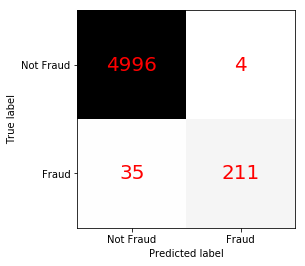

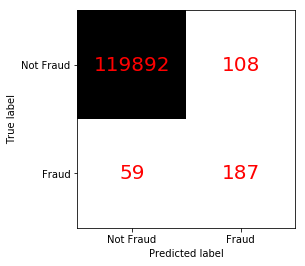

In [ ]:
thisResult = {}
thisResult['fit_time'] = fit_time
thisResult['clf'] = fit_time
thisResult['fit_statistics'] = clf.fit_statistics
for case in data:
    thisResult[case] = {}
    thisResult[case]['yPred'] = clf.predict(data[case]['X'])
    thisResult[case]['f1'] = f1_score(data[case]['y'], thisResult[case]['yPred'])
    thisResult[case]['cr'] = classification_report(data[case]['y'], thisResult[case]['yPred'], target_names=names)
    print(f'case: {case}, f1={thisResult[case]["f1"]}')
    thisResult[case]['cm'] = plotConfusionMatrix(data[case]['y'], thisResult[case]['yPred'], names, savefig=f'NN_sa_confusion_{case}.png')
print(f'Fitness function evaluations = {thisResult["fit_statistics"]["fitness_evals"]}')
results['Simulated Annealing'] = thisResult

In [ ]:
results['Simulated Annealing']['fit_statistics']

{'iters': 5000,
 'time': 39.184094699999996,
 'fitness_evals': 9364,
 'best_state': array([-0.74738342,  1.55983758,  0.67681846,  0.34693036,  1.15597902,
         0.97699174, -0.29775907, -0.85589773,  0.23687796,  0.699765  ,
         0.75845999,  0.60747807,  0.56188227, -0.46812731, -1.4237088 ,
         1.01918706, -0.27322929, -0.79575208,  0.06241204, -0.65020154,
         0.50109783,  0.800259  , -0.33939424,  0.79697984,  0.61825675,
        -0.13366111,  0.14682516, -0.59918028,  0.23802648, -0.16449428,
        -0.29030182, -0.81846822,  0.24476938, -1.04519769,  0.83178077,
         0.37583599,  0.63729501, -0.47201065,  0.34525067, -0.6479019 ,
         0.00568587,  0.30595673, -0.18520107,  1.14070217,  0.41818596,
         0.93864825,  0.12598366, -0.68715346, -0.53909676, -0.81776225,
         1.04474809, -0.14709285,  1.66875974,  1.5458124 ,  0.62977196,
        -2.09714624, -0.61547531,  0.51878879,  0.94869119,  0.59232093,
         1.81093665,  1.36582771, -1.0937

# Genetic Algorithm

In [ ]:
np.random.seed(7)
clf = mlrose.NeuralNetwork(hidden_nodes=[4], algorithm='genetic_alg', pop_size=500, mutation_prob=0.1, early_stopping=True, max_attempts=50, max_iters=100, elite=0.)
time_start = perf_counter()
clf.fit(X, y)
fit_time = perf_counter() - time_start
print(f'fit_time = {fit_time}')

running with elite = 0.0


In [ ]:
thisResult = {}
thisResult['fit_time'] = fit_time
thisResult['clf'] = fit_time
thisResult['fit_statistics'] = clf.fit_statistics
for case in data:
    thisResult[case] = {}
    thisResult[case]['yPred'] = clf.predict(data[case]['X'])
    thisResult[case]['f1'] = f1_score(data[case]['y'], thisResult[case]['yPred'])
    thisResult[case]['cr'] = classification_report(data[case]['y'], thisResult[case]['yPred'], target_names=names)
    print(f'case: {case}, f1={thisResult[case]["f1"]}')
    thisResult[case]['cm'] = plotConfusionMatrix(data[case]['y'], thisResult[case]['yPred'], names, savefig=f'NN_ga_confusion_{case}.png')
print(f'Fitness function evaluations = {thisResult["fit_statistics"]["fitness_evals"]}')
results['Genetic Algorithm'] = thisResult

In [ ]:
print(results['Genetic Algorithm']['train']['cr'])
print(results['Genetic Algorithm']['test']['cr'])
print(results['Genetic Algorithm']['fit_time'])

In [ ]:
results['Genetic Algorithm']['fit_statistics']